# Analyze Representations in Path-Integrating Recurrent Neural Networks

## Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np
import skdim

from neurometry.dimension.dimension import skdim_dimension_estimation
from neurometry.dimension.dimension import plot_dimension_experiments

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs
import torch

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry


INFO:root:Using pytorch backend
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Load Single-Agent RNN

In [17]:
from neurometry.datasets.load_rnn_grid_cells import load_activations

In [34]:
epochs = [0, 15, 55, "final"]
activations, rate_maps, state_points = load_activations(epochs, type="single")

Loaded epochs [0, 15, 55, 'final'] of single agent model.
There are 4096 grid cells with 20 x 20 environment resolution, averaged over 1 trajectories.
There are 400 data points in the 4096-dimensional state space.
There are 400 data points averaged over 1 trajectories in the 4096-dimensional state space.


## Load Dual-Agent RNN

In [33]:
epochs = [10, 25, 80, "final"]
activations, rate_maps, state_points = load_activations(epochs, type="dual")

Loaded epochs [10, 25, 80, 'final'] of dual agent model.
There are 4096 grid cells with 20 x 20 environment resolution, averaged over 1 trajectories.
There are 400 data points in the 4096-dimensional state space.
There are 400 data points averaged over 1 trajectories in the 4096-dimensional state space.


## Single-Agent RNN

Load activations

In [2]:
# Loading single agent model

parent_dir = (
    "/Users/facosta/Desktop/code/neurometry/neurometry/datasets/rnn_grid_cells/"
)
model_folder = "Single agent path integration/Seed 1 weight decay 1e-06/"
model_parameters = "steps_20_batch_200_RNN_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_1e-06/"
activations_dir = parent_dir + model_folder + model_parameters + "activations/"

activations = np.load(activations_dir + "activations_single_agent.npy")
print(activations.shape)

rate_maps = np.load(activations_dir + "rate_map_single_agent.npy")
print(rate_maps.shape)

state_points = activations.reshape(activations.shape[0], -1)
print(state_points.shape)

(4096, 20, 20, 50)
(4096, 400)
(4096, 20000)


Plot rate maps

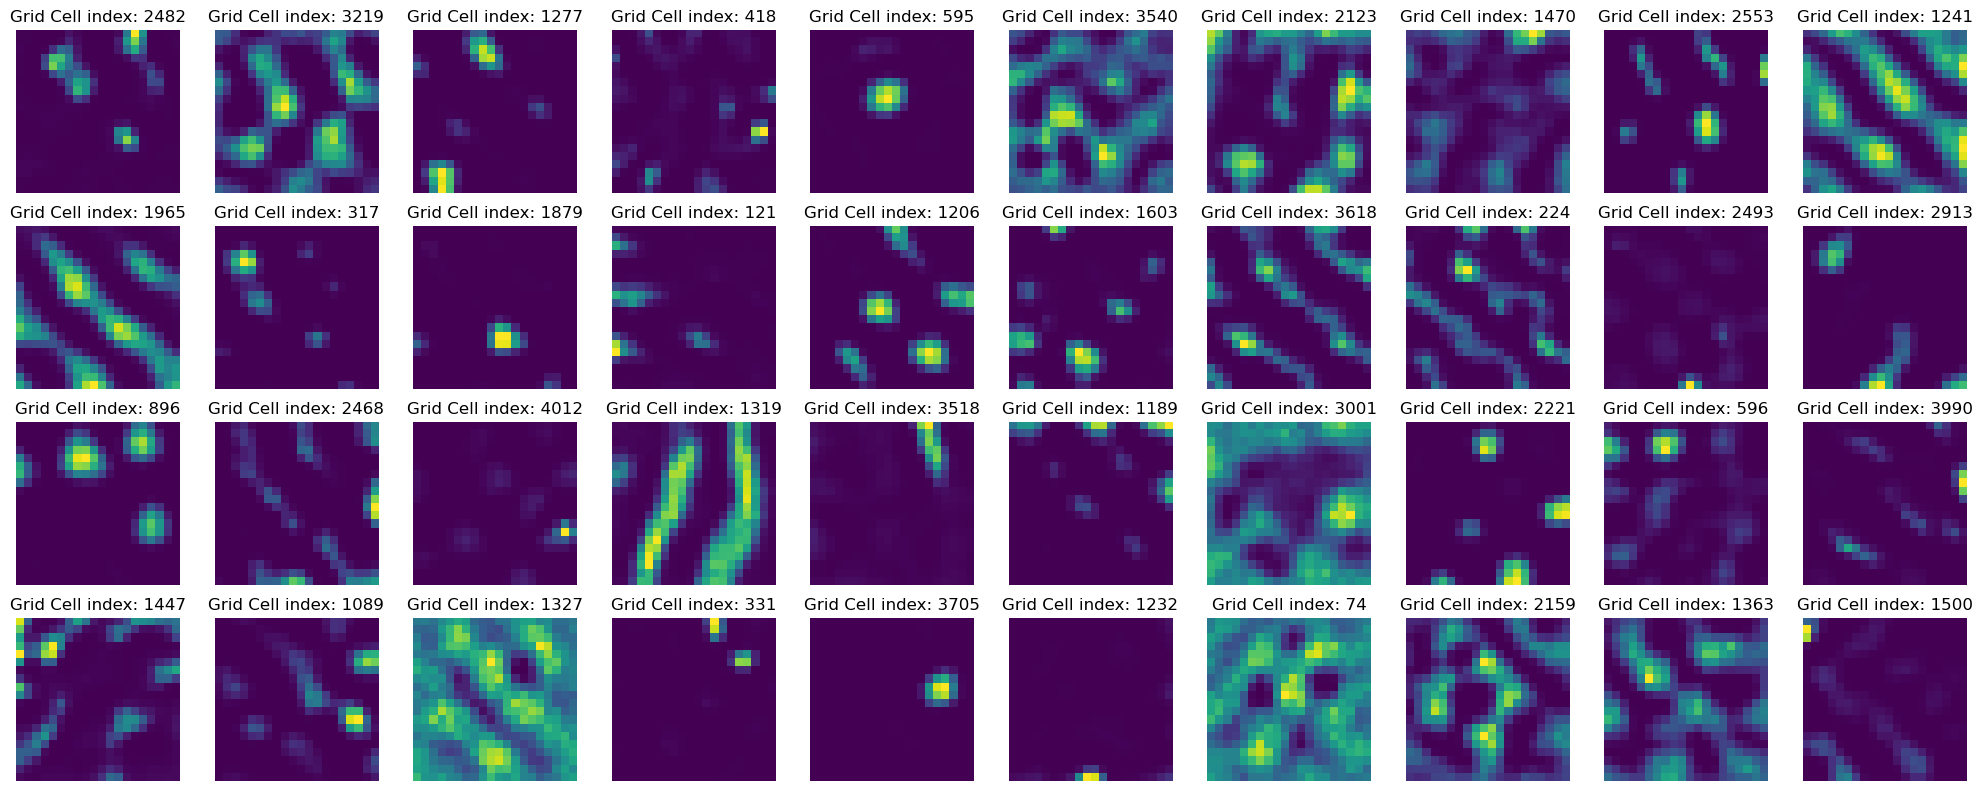

In [6]:
num_plots = 40
idxs = np.random.randint(0, 4095, num_plots)

rows = 4
cols = num_plots // rows + (num_plots % rows > 0)


fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

for i in range(rows):
    for j in range(cols):
        if i * cols + j < num_plots:
            gc = np.mean(activations[idxs[i * cols + j]], axis=2)
            axes[i, j].imshow(gc)
            axes[i, j].set_title(f"Grid Cell index: {idxs[i * cols + j]}")
            axes[i, j].axis("off")
        else:
            axes[i, j].axis("off")

plt.tight_layout()
plt.show()

### Estimate Dimension

In [3]:
neural_manifold = rate_maps.T


num_trials = 10
# methods = [method for method in dir(skdim.id) if not method.startswith("_")]
methods = ["MLE", "KNN", "TwoNN", "CorrInt", "lPCA"]

id_estimates = {}
for method_name in methods:
    method = getattr(skdim.id, method_name)()
    estimates = np.zeros(num_trials)
    for trial_idx in range(num_trials):
        method.fit(neural_manifold)
        estimates[trial_idx] = np.mean(method.dimension_)
    id_estimates[method_name] = estimates

In [6]:
neural_manifold.shape

(400, 4096)

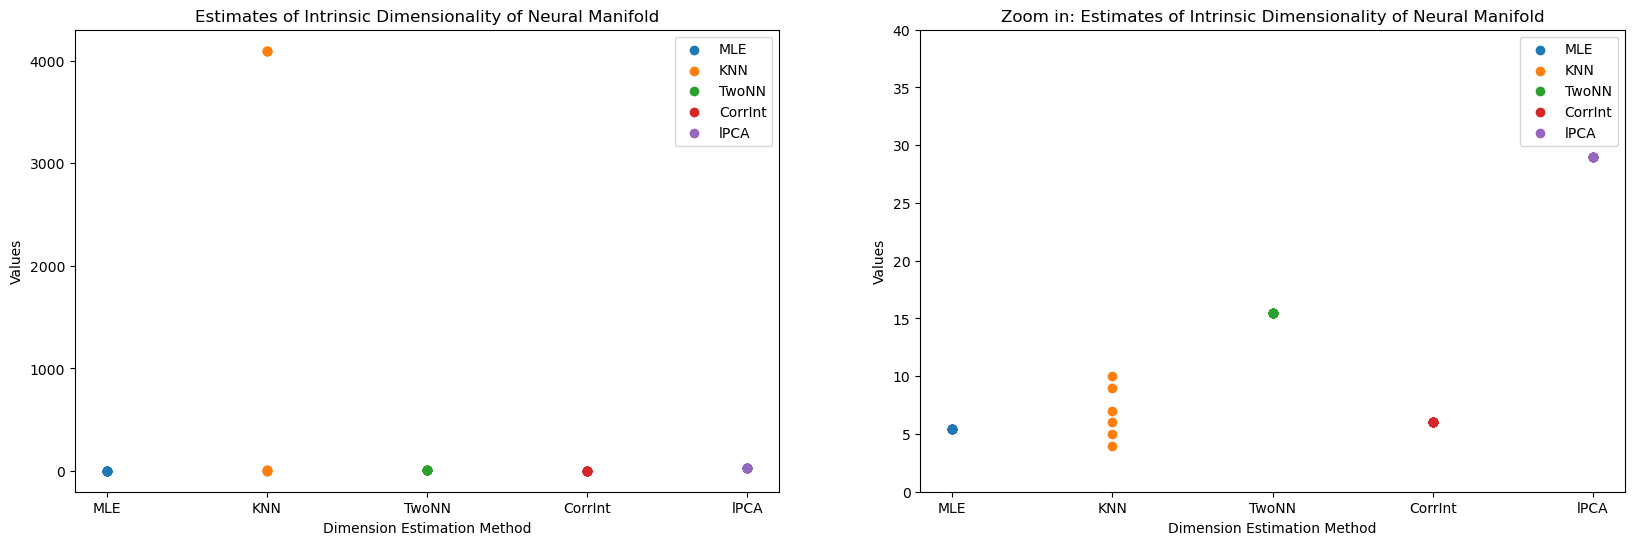

In [18]:
# make side by side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, method in enumerate(methods):
    y = id_estimates[method]
    x = np.repeat(i, len(y))
    axes[0].scatter(x, y, label=method)
    axes[1].scatter(x, y, label=method)

axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods)
axes[0].set_xlabel("Dimension Estimation Method")
axes[0].set_ylabel("Values")
axes[0].set_title("Estimates of Intrinsic Dimensionality of Neural Manifold")
axes[0].legend()

axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods)
axes[1].set_xlabel("Dimension Estimation Method")
axes[1].set_ylabel("Values")
axes[1].set_ylim([0, 40])
axes[1].set_title("Zoom in: Estimates of Intrinsic Dimensionality of Neural Manifold")
axes[1].legend();

estimate extrinsic with PCA, then do nonlinear dim est

### Estimate Topology

'compute_persistence_diagrams' executed in 1.1178s


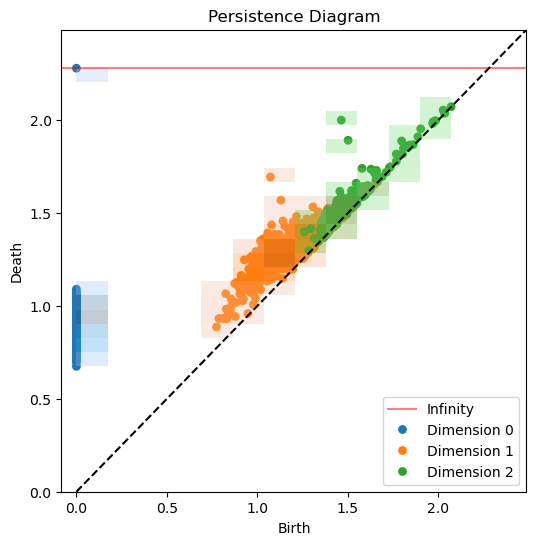

In [19]:
import neurometry.curvature.viz as viz
import neurometry.curvature.persistent_homology as persistent_homology


diagrams = persistent_homology.compute_persistence_diagrams(
    neural_manifold, maxdim=2, n_threads=-1
)


viz.plot_persistence_diagrams(diagrams, density=True)

'compute_persistence_diagrams' executed in 1.0917s


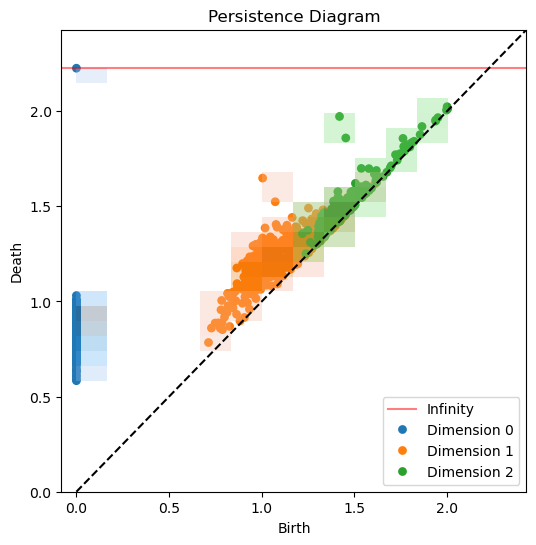

In [20]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit(neural_manifold)
# project data onto principal components
pc = pca.transform(neural_manifold)

diagrams = persistent_homology.compute_persistence_diagrams(pc, maxdim=2, n_threads=-1)


viz.plot_persistence_diagrams(diagrams, density=True)

## Dual-Agent RNN